<a href="https://colab.research.google.com/github/glima91/mestrado-redes-neurais/blob/main/Atividade_3_Implementa%C3%A7%C3%A3o_da_fase_forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementação da fase forward

Para esta atividade deve ser feita uma base para o problema XOR, que deve ter somente 4 exemplos e não vai ter separação de treino e teste.

A arquitetura apresentada no fórum que trata sobre a fase forward do backpropagation https://ava.cefor.ifes.edu.br/mod/forum/view.php?id=1702157 deve ser implementada, em uma classe que herde BaseEstimator, ClassifierMixin. Os pesos podem ser devidos "manualmente" dentro do método fit. Só a fase forward será implementada. Portanto, só o método predict (ou predict_proba) deve ser implementado usando os cálculos que discutimos no fórum.

Apresente um gráfico mostrando a separação das classes usando um meshgrid, como feito nas tarefas anteriores.

A forma de entrega é como a das demais tarefas, um link para um jupyter notebook no github.

In [25]:
# Importação de bibliotecas
from sklearn.base import BaseEstimator, ClassifierMixin
import random
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from scipy.special import expit
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from scipy.special import expit

In [26]:
# Funções para plotagem
def plotDataset(X,y):
  plt.xlabel('X1')
  plt.ylabel('X2')
  for k in set(y):
    plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

def plothiperplano(X,y,vetor,intercept=0):
  X0min = min(X[:,0])
  X0max = max(X[:,0])
  xs = np.linspace(X0min,X0max,num = 2)
  ys = (-vetor[0]/vetor[1]) * xs-intercept/vetor[1]
  plt.plot(xs,ys)

def define_axes(X):
  margin = 5.0
  min1,max1 = X[:,0].min(),X[:,0].max()
  min2,max2 = X[:,1].min(),X[:,1].max()
  return [min1 - margin,max1 + margin,min2 - margin,max2 + margin]


def plotPredictions(clf,X):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X = np.c_[x0.ravel(),x1.ravel()]
  ypred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha = 0.2)

In [27]:
# Criação do dataset XOR
def criaDatasetXor(n=1000):
  X, y = make_blobs(n_samples=n, centers=[[0,0], [1,0],[1,1],[0,1]], cluster_std=0.0)
  y = np.array(y%2, dtype=int)
  return X, y

In [28]:
# Cria dataset com 4 elementos
Xtr,ytr = criaDatasetXor(n=4)

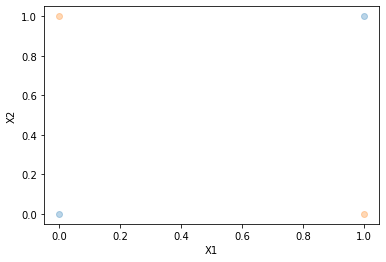

In [29]:
# Plot dos elementos do dataset XOR
plotDataset(Xtr, ytr)

In [30]:
# Implementacao de classes abstratas
class TrainingAlgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass

class PseudoInversa(TrainingAlgorithm):
  def getW(self, X,y):
    print(np.linalg.pinv(X) @ y)
    return np.linalg.pinv(X) @ y

In [31]:
# Implementação do MLP

def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

def tanh(a):
  return expit(a)*2-1

class FixedWeights():
  def __init__(self):
    self.n_hidden = 2
    self.activation = tanh
    self.training = PseudoInversa()
  
  def fit(self, X, y):
    self.wih = np.array([[1.75, 0.95, -0.9], [-1.75, 0.85, -0.9]]).T
    H = self.activation(includebias(X) @ self.wih)
    Hb = includebias(H)
    self.who = self.training.getW(Hb,y)

  def predict(self, X, g=None):
    Xb = includebias(X)
    H = self.activation(Xb @ self.wih)
    Hb = includebias(H)
    return Hb @ self.who


class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self,training_algorithm=FixedWeights()):
    # training algorithm
    self.training_algorithm = training_algorithm
   
  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels) * 2 -1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)

  def predict(self, X, y=None):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <=2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

In [32]:
# Treinamento e avaliação do modelo
model = MLP()
model.fit(Xtr,ytr)
ypred = model.predict(Xtr,ytr)

print(f"Accuracy:  {sum(ytr == ypred)/len(ytr)}")

[[ 19.35263336]
 [-13.90257197]
 [ 14.73646912]]
Accuracy:  1.0


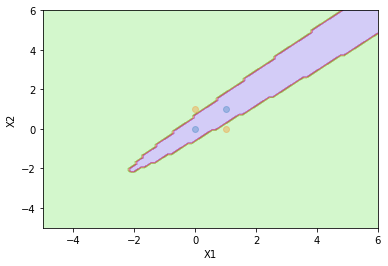

In [33]:
# Análise da separação entre as classes
plotDataset(Xtr,ytr)
plotPredictions(model,Xtr)